<a href="https://colab.research.google.com/github/manjulamishra/DS-Sprint-01-Dealing-With-Data/blob/master/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [1]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [2]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [3]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have twice as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.2 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=152.72285258605484, mobile=True), User(purchased=True, time_on_site=65.34240706507777, mobile=True), User(purchased=False, time_on_site=188.51373749059616, mobile=True), User(purchased=False, time_on_site=123.01529027413748, mobile=False), User(purchased=False, time_on_site=198.7573219858361, mobile=True), User(purchased=True, time_on_site=74.86056951241257, mobile=False), User(purchased=False, time_on_site=123.47331927213715, mobile=True), User(purchased=False, time_on_site=61.157198432084634, mobile=True), User(purchased=False, time_on_site=278.3411977849419, mobile=False), User(purchased=False, time_on_site=42.97179069466819, mobile=True)]


In [4]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,152.722853,True
1,True,65.342407,True
2,False,188.513737,True
3,False,123.015290,False
4,False,198.757322,True


In [5]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.259441521218255,5.754102119908707,6.8627075023206485,6.901584108208137,9.601606572642314,9.76164849041932,10.488034946990288,10.80291522995047,10.868433504920752,10.943376726859306,...,569.0804622599063,569.2681721178742,570.9991607910059,575.2954832371427,575.8607077500972,578.0345698284515,581.4471008795175,582.898589809126,588.0654030532419,596.0048179578937
purchased,,,,,,,,,,,,,,,,,,,,,
False,1,1,1,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,1
True,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.669, 123.409]","(123.409, 241.558]","(241.558, 359.707]","(359.707, 477.856]","(477.856, 596.005]"
purchased,,,,,
False,261,288,177,52,51
True,63,60,39,5,4


In [7]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.669, 123.409]","(123.409, 241.558]","(241.558, 359.707]","(359.707, 477.856]","(477.856, 596.005]"
purchased,,,,,
False,0.805556,0.827586,0.819444,0.912281,0.927273
True,0.194444,0.172414,0.180556,0.087719,0.072727


In [8]:
# That seems counter to our hypothesis
# More time on the site seems to have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.912,0.801333
True,0.088,0.198667


In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
#load the data https://raw.githubusercontent.com/manjulamishra/DS-Sprint-01-Dealing-With-Data/master/module4-databackedassertions/persons.csv

# Use what we did live in lecture as an example
import pandas as pd
persons_URL = 'https://raw.githubusercontent.com/manjulamishra/DS-Sprint-01-Dealing-With-Data/master/module4-databackedassertions/persons.csv'
persons_df = pd.read_csv(persons_URL)
print(persons_df)

In [81]:
persons.df.head()

NameError: ignored

NameError: ignored

In [67]:
import numpy as np
dtype.(persons_df['age'])

SyntaxError: ignored

In [46]:
help(persons_df.plot.bar)

Help on method bar in module pandas.plotting._core:

bar(x=None, y=None, **kwds) method of pandas.plotting._core.FramePlotMethods instance
    Vertical bar plot
    
    .. versionadded:: 0.17.0
    
    Parameters
    ----------
    x, y : label or position, optional
        Coordinates for each point.
    **kwds : optional
        Keyword arguments to pass on to :py:meth:`pandas.DataFrame.plot`.
    
    Returns
    -------
    axes : matplotlib.AxesSubplot or np.array of them



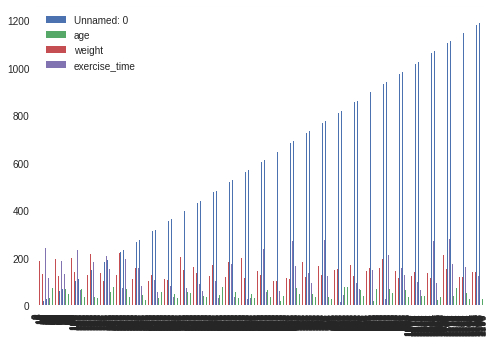

In [47]:
persons_df.plot.bar()

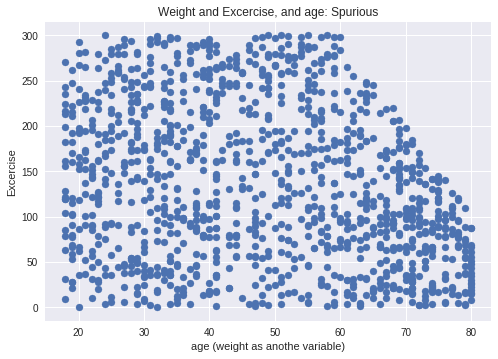

In [48]:
import matplotlib.pyplot as plt

plt.scatter(persons_df['age'], persons_df['exercise_time'])
plt.xlabel("age (weight as anothe variable)")
plt.ylabel("Excercise")
plt.title("Weight and Excercise, and age: Spurious")
plt.show()

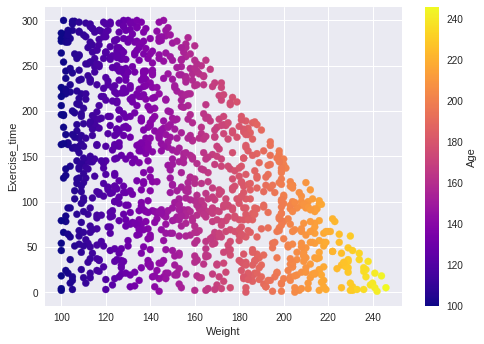

In [50]:
a = persons_df['age']
b = persons_df['weight']
c = persons_df['exercise_time']
plt.scatter(b, c, c = b, cmap = 'plasma');
plt.xlabel('Weight')
plt.ylabel('Exercise_time')
plt.colorbar().set_label('Age')

persons_df['age'] = a
b = persons_df['weight'] = b
c = persons_df['exercise_time'] = c

In [0]:

persons_df['age'] = a
persons_df['weight'] = b
persons_df['exercise_time'] = c

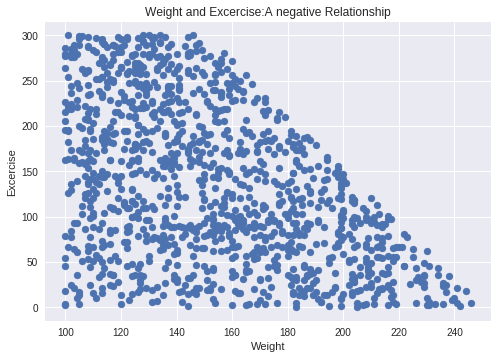

In [72]:
import matplotlib.pyplot as plt

plt.scatter(persons_df['weight'], persons_df['exercise_time'])
plt.xlabel("Weight")
plt.ylabel("Excercise")
plt.title("Weight and Excercise:A negative Relationship")
plt.show()

In [0]:
plt.scatter?

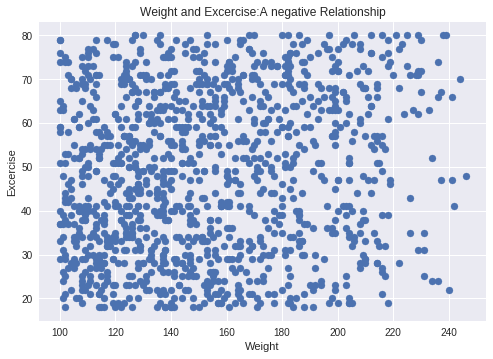

In [79]:
import matplotlib.pyplot as plt

plt.scatter(persons_df['weight'], persons_df['age'])
plt.xlabel("Weight")
plt.ylabel("Excercise")
plt.title("Weight and Excercise:A negative Relationship")
plt.show()

In [76]:
df = pd.crosstab([persons_df['weight'], time_bins], persons_df['exercise_time'],
                 normalize='columns')
df

exercise_time              0    1    2         3    4         5    6    8    \
weight time_on_site                                                           
100    (4.669, 123.409]    0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0   
       (123.409, 241.558]  0.0  0.0  0.0  0.000000  0.2  0.000000  0.0  0.0   
       (241.558, 359.707]  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0   
       (359.707, 477.856]  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0   
       (477.856, 596.005]  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0   
101    (4.669, 123.409]    0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0   
       (123.409, 241.558]  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0   
       (241.558, 359.707]  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0   
       (359.707, 477.856]  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0   
       (477.856, 596.005]  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0   
102    (4.669, 123.409]    0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0   
       (123.409, 241.558]  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0   
       (241.558, 359.707]  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0   
       (359.707, 477.856]  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0   
       (477.856, 596.005]  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0   
103    (4.669, 123.409]    0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0   
       (123.409, 241.558]  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0   
       (241.558, 359.707]  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0   
       (359.707, 477.856]  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0   
       (477.856, 596.005]  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0   
104    (4.669, 123.409]    0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0   
       (123.409, 241.558]  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0   
       (241.558, 359.707]  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0   
       (359.707, 477.856]  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0   
       (477.856, 596.005]  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0   
105    (4.669, 123.409]    0.0  0.0  0.0  0.166667  0.0  0.000000  0.0  0.0   
       (123.409, 241.558]  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0   
       (241.558, 359.707]  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0   
       (359.707, 477.856]  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0   
       (477.856, 596.005]  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0   
...                        ...  ...  ...       ...  ...       ...  ...  ...   
239    (4.669, 123.409]    0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.5   
       (123.409, 241.558]  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0   
       (241.558, 359.707]  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0   
       (359.707, 477.856]  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0   
       (477.856, 596.005]  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0   
240    (4.669, 123.409]    0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0   
       (123.409, 241.558]  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0   
       (241.558, 359.707]  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0   
       (359.707, 477.856]  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0   
       (477.856, 596.005]  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0   
241    (4.669, 123.409]    0.0  0.0  0.0  0.000000  0.0  0.142857  0.0  0.0   
       (123.409, 241.558]  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0   
       (241.558, 359.707]  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0   
       (359.707, 477.856]  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0   
       (477.856, 596.005]  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0   
242    (4.669, 123.409]    0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0   
       (123.409, 241.558]  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0   
       (241.558, 359.707]  0.0  0.0  0.0  0.000000

In [78]:
pd.crosstab(time_bins, [persons_df['weight'], persons_df['exercise_time'], persons_df['age']],
            normalize='columns').plot(kind = 'bar', stacked = False);

KeyboardInterrupt: ignored

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
2.  What are the relationships between the variables?
3.  Which relationships are "real", and which spurious?


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspierd by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)